# Chapter 9 - Embedding Graphs

In this notebook, we experiment with the *graph2vec* algorithm to embed whole graphs. We illustrate this over two datasets from ther National Cancer Institute (NCI); each dataset contains labelled graph representations of chemical compounds; each compound is labelled as active (label = 1) or inactive (label = 0).

We perform the following experiments:

* supervised learning (binary classification)
* graph-based feature extraction and feature importance
* unsupervised learning (clustering)


## Requirements

* download graph2vec code from (we used the May 2020 version): https://github.com/benedekrozemberczki/graph2vec/tree/be7fc2ac44706f9664b6636cea5df477e8a6bb06/src
* the NCI1 and NCI109 datasets
    
Also set the path(s) in the cell below. 

NB: On Windows, there could be issues with the graph2vec code. One way to fix this is to change “/“ to “\\\\” on lines 63 and 97 of graph2vec.py  

In [1]:
## pick one of the two supplied datasets

datadir = '../Datasets/NCI1/'
#datadir = '../Datasets/NCI109/'

## location of graph2vec python code
g2v = '~/Tools/graph2vec/'

## random state for reproducibility with train/test splits
RS = 99

In [2]:
import pandas as pd
import numpy as np
import igraph as ig
import json
import os
import matplotlib.pyplot as plt
import umap, umap.plot
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as knn 
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier as rfc 
from collections import Counter


## Prepare datasets for graph2vec

* save each graph in a json file, where the filenames are 0-based integers
* each file contains a list of edges and dictionary of node features


In [3]:
## read data from NCI folder
edges = datadir+'DS_A.txt'
graph_id = datadir+'DS_graph_indicator.txt'
graph_label = datadir+'DS_graph_labels.txt'
node_label = datadir+'DS_node_labels.txt'

## read edges, build overall graph
X = np.array(pd.read_csv(edges,header=None))
E = [list(x) for x in X]
G = ig.Graph.TupleList(E, directed=True)

## read subgraph membership (1-based)
m = [int(x) for x in np.array(pd.read_csv(graph_id,header=None))]

## some vertices do not appear in any edges
## we add those as isolated nodes for easier processing.
## collect all vertex names 
vertices = set(G.vs['name'])
## add difference
v = set(np.arange(1,len(m)+1))
diff = v.difference(vertices)
G.add_vertices(list(diff))

## parameters for plotting
G.vs['size'] = 10
G.vs['color'] = 'darkgrey'
G.es['color'] = 'grey'
G.es['arrow_size'] = .33
G.vs['label_size'] = 8

## mapping nodes in order of name
idx = list(np.argsort(G.vs['name']))

## assign subgraph
for i in range(len(m)):
    G.vs[idx[i]]['graph'] = m[i]

## verify with graph label list -- should output 'True'
l = [G.vs[i]['graph'] for i in idx]
l == m


True

In [4]:
## read node labels
l = [int(x) for x in np.array(pd.read_csv(node_label,header=None))]
for i in range(len(l)):
    G.vs[idx[i]]['label'] = l[i]
G = G.as_undirected()

## read graph labels
gl = [int(x) for x in np.array(pd.read_csv(graph_label,header=None))]

## build the subgraphs and save json files in the data directory
## this takes a few minutes (and some amount of disk space!)
## we also count nodes and edges for EDA
vc = []
ec = []

for gp in np.arange(1,np.max(G.vs['graph'])+1):
    v = [v for v in G.vs if v['graph']==gp]
    sg = G.subgraph(v)
    vc.append(sg.vcount())
    ec.append(sg.ecount())
    sg_edges = [list(e.tuple) for e in sg.es]
    #sg_features = {str(v.index):str(v['label']) for v in sg.vs}
    sg_json = {"edges":sg_edges}
    fn = datadir+str(gp-1)+'.json'
    with open(fn,'w') as fp:
        json.dump(sg_json,fp)

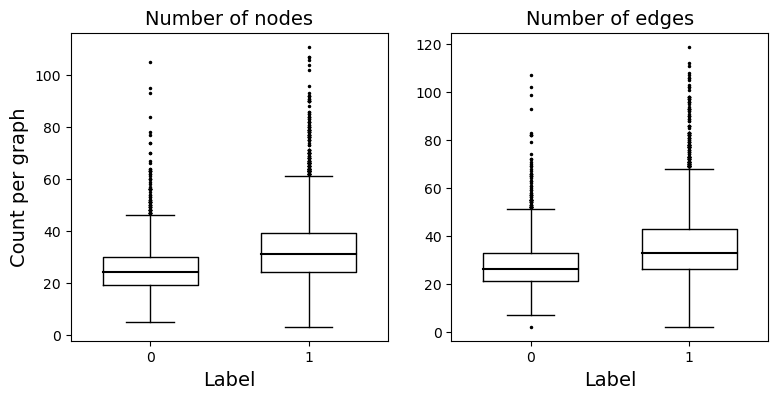

In [5]:
## Plot number of nodes/edges for graphs with label 0 and 1 resp.
a = [vc[i] for i in range(len(vc)) if gl[i]==0]
b = [vc[i] for i in range(len(vc)) if gl[i]==1]
c = [ec[i] for i in range(len(ec)) if gl[i]==0]
d = [ec[i] for i in range(len(ec)) if gl[i]==1]

plt.subplots(1,2,figsize=(9,4))
plt.subplot(121)
plt.boxplot([a,b],labels=['0','1'],widths=.6, 
            flierprops = dict(marker='.', markerfacecolor='black', markersize=3,linestyle='none'),
            medianprops = dict(linestyle='-', linewidth=1.5, color='black'))
plt.ylabel('Count per graph',fontsize=14);
plt.xlabel('Label',fontsize=14)
plt.title('Number of nodes',fontsize=14);

plt.subplot(122)
plt.boxplot([c,d],labels=['0','1'],widths=.6, 
            flierprops = dict(marker='.', markerfacecolor='black', markersize=3,linestyle='none'),
            medianprops = dict(linestyle='-', linewidth=1.5, color='black'))
#plt.ylabel('Count per graph',fontsize=11)
plt.xlabel('Label',fontsize=14);
plt.title('Number of edges',fontsize=14);
#plt.savefig('nci_counts.eps');


## Run graph2vec with 64 dimensions

You may get the following warning:

```
graph2vec.py:104: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  out.append([int(identifier)] + list(model.docvecs["g_"+identifier]))
```

Changing docvec to dv on line 104 solves this issue.


In [6]:
## run graph2vec with magic '%run'
cmd = g2v+'graph2vec.py --input-path '+datadir+' --output-path '+datadir+\
'NCI64.csv --dimensions 64 --workers 1' 
%run $cmd

## another option: run with os.system:
#cmd = 'python '+g2v+'graph2vec.py --input-path '+datadir+' --output-path '+datadir+\
#'NCI64.csv --dimensions 64 --workers 1' 
#x = os.system(cmd+' >/dev/null 2>&1')



Feature extraction started.



100%|██████████████████████████████████████████████████████████| 4110/4110 [00:00<00:00, 4140.27it/s]



Optimization started.



<Figure size 640x480 with 0 Axes>

## Classification in embedded space

* we use 80% for training, 20% for testing
* we use a random forest classifiers with 100 trees


In [7]:
## divide data into training and testing
D = pd.read_csv(datadir+'NCI64.csv')
D = np.array(D.drop(columns=['type']))
X_train, X_test, y_train, y_test = train_test_split(D, gl, test_size=0.2, random_state=RS)


In [8]:
## random forest classifier -- accuracy
rfc_mdl = rfc(n_estimators=100, criterion='entropy')
rfc_mdl.fit(X_train,y_train)
y_pred = rfc_mdl.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6192214111922141


## Re-run graph2vec -- 1024 dimensions

In [9]:
## run graph2vec with magic '%run'
cmd = g2v+'graph2vec.py --input-path '+datadir+' --output-path '+datadir+\
'NCI1024.csv --dimensions 1024 --workers 1' 
%run $cmd

## another option: run with os.system:
#cmd = 'python '+g2v+'graph2vec.py --input-path '+datadir+' --output-path '+datadir+\
#'NCI1024.csv --dimensions 1024 --workers 1' 
#x = os.system(cmd+' >/dev/null 2>&1')



Feature extraction started.



100%|██████████████████████████████████████████████████████████| 4110/4110 [00:00<00:00, 4269.38it/s]



Optimization started.



## Visualize embeddings 

* we color w.r.t. graph label
* we see a few outliers (what are those?), but in general, no clear class separation (but this is only 2D!)

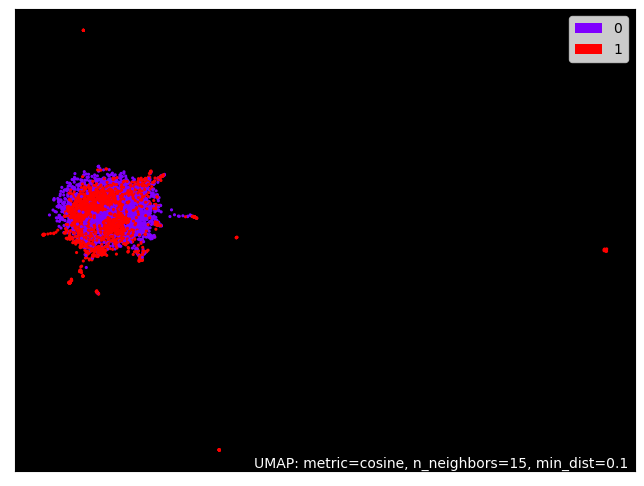

In [10]:
D = pd.read_csv(datadir+'NCI1024.csv')
D = np.array(D.drop(columns=['type']))
U = umap.UMAP(metric='cosine').fit(D)
umap.plot.points(U,labels=np.array(gl),theme='fire',width=800,height=600);


## Classification in embedded space

* we use 80% for training, 20% for testing
* we use random forest classifiers
* we also try mapping from 1024 to 64 dimensions

Possible project: 
* divide training set into training and validation 
* use this to select best model by trying several hyperparameters

In [11]:
## random forest classifier
X_train, X_test, y_train, y_test = train_test_split(D, gl, test_size=0.2, random_state=RS)
rfc_mdl = rfc(n_estimators=100, criterion='entropy')
rfc_mdl.fit(X_train,y_train)
y_pred = rfc_mdl.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6301703163017032


In [12]:
## try in lower dimension -- same random_seed to get same split
U = umap.UMAP(n_components=64, metric='cosine').fit(D).embedding_
X_train, X_test, y_train, y_test = train_test_split(U, gl, test_size=0.2, random_state=RS)
rfc_mdl = rfc(n_estimators=100, criterion='entropy')
rfc_mdl.fit(X_train,y_train)
y_pred = rfc_mdl.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.927007299270073


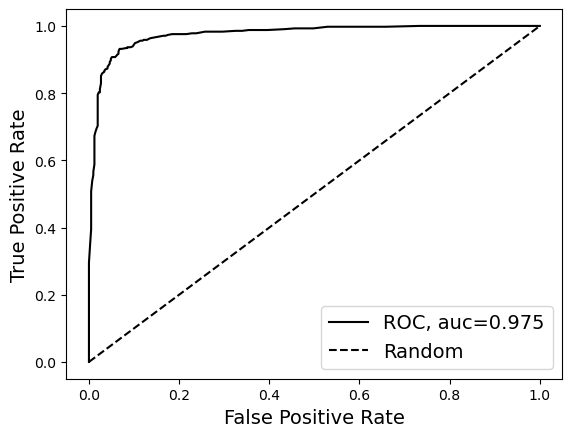

In [13]:
## ROC curve
y_probs = rfc_mdl.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_probs)
auc = metrics.roc_auc_score(y_test, y_probs)
plt.plot(fpr,tpr,label="ROC, auc="+str('%.3f' % auc),color='black')
plt.plot([0,1],[0,1],'--',label='Random',color='black')
plt.legend(loc=4,fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14);
#plt.savefig('nci_64d_roc.eps');


In [14]:
## bootstrap confidence interval for the AUC
def bootstrap(y_test,y_probs,n_boot=1000):
    y_pred = np.array(y_probs)
    y_true = np.array(y_test)
    scores = []
    rng = np.random.RandomState(RS)
    for i in range(n_boot):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        sc = roc_auc_score(y_true[indices], y_pred[indices])
        scores.append(sc)
    sorted_scores = np.array(scores)
    sorted_scores.sort()
    conf_lo = sorted_scores[int(0.05 * len(sorted_scores))]
    conf_up = sorted_scores[int(0.95 * len(sorted_scores))]
    return (conf_lo, conf_up)
bootstrap(y_test,y_probs)

(0.9671893991047342, 0.9826759377815717)

## Subgraph features

- we compute several statistics on the graphs
 - number of nodes, edges, density 
 - degree distribution 
 - number of components, size of the giant component
 - transitivity
 - degree assortativity
 - coreness distribution
 - node labels distribution
 
- we compare those for the two classes of graphs
- we re-try binary classification when adding those features


label: 0


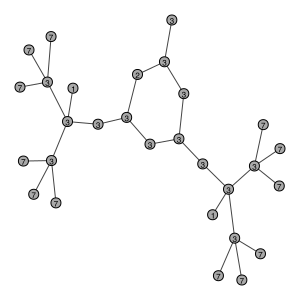

In [15]:
## example of a graph with label 0
gp = 800
v = [v for v in G.vs if v['graph']==gp]
sg = G.subgraph(v)
print('label:',gl[gp-1])
ig.plot(sg,bbox=(0,0,300,300))
#ig.plot(sg,target='nci_0.eps',bbox=(0,0,300,300))


label: 1


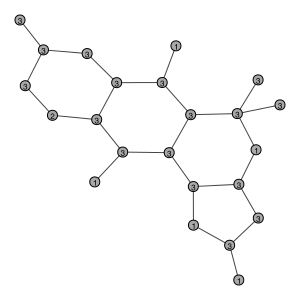

In [16]:
## example of a graph with label 1
gp = 2300
v = [v for v in G.vs if v['graph']==gp]
sg = G.subgraph(v)
print('label:',gl[gp-1])
ig.plot(sg,bbox=(0,0,300,300))
#ig.plot(sg,target='nci_1.eps',bbox=(0,0,300,300))


### Build graph-based features for each compound (graph)

In [17]:
def degrees(sg,md):
    ctr = Counter(sg.degree())
    return [ctr[i] for i in range(md+1)]

def core(sg,mc):
    ctr = Counter(sg.coreness())
    return [ctr[i] for i in range(mc+1)]

def labels(sg,ml):
    ctr = Counter(sg.vs['label'])
    return [ctr[i+1] for i in range(ml)]


In [18]:
## Compute features for each graph
## this takes a few minutes as there are many graphs

L = []
md = np.max(G.degree())
mc = np.max(G.coreness())
ml = np.max(G.vs['label'])

for gp in np.arange(1,np.max(G.vs['graph'])+1):
    v = [v for v in G.vs if v['graph']==gp]
    sg = G.subgraph(v)
    ## node and edge counts, density
    x = [sg.vcount(),sg.ecount(),sg.ecount()/sg.vcount()]
    ## number of components, relative size of giant component
    x.extend([np.max(sg.connected_components().membership)+1,sg.connected_components().giant().vcount()/sg.vcount()])
    ## transitivity, assortativity
    x.extend([sg.transitivity_undirected(),sg.transitivity_avglocal_undirected()])
    ## assortativity
    a = sg.assortativity_degree()
    if np.isnan(a):
        a=0
    x.extend([a])
    ## degree distribution
    x.extend(degrees(sg,md))
    ## coreness distribution
    x.extend(core(sg,mc))
    ## node labels distribution
    x.extend(labels(sg,ml))
    L.append(x)

In [19]:
## store all features in a dataframe
col = ['nodes','edges','density','components','giant','trans','local trans','assort']
col.extend(['deg'+str(i) for i in np.arange(md+1)])
col.extend(['core'+str(i) for i in np.arange(mc+1)])
col.extend(['label'+str(i+1) for i in np.arange(ml)])
F = pd.DataFrame(L,columns=col)
F['label'] = gl


In [20]:
## EDA of the graphs
print(F.shape[0],'graphs')
print(sum(F['label']),'have label 1')
print('avg nodes:',np.mean(F['nodes']))
print('avg edges:',np.mean(F['edges']))


4110 graphs
2057 have label 1
avg nodes: 29.8654501216545
avg edges: 32.3


### Add those features are re-do binary classification

In [21]:
## binary classification with all features
Fp = pd.concat([pd.DataFrame(U,columns=['emb_'+str(i) for i in np.arange(0,U.shape[1])]),F],axis=1)
## divide data into training and testing
A = np.array(Fp.drop(columns=['label']))
X_train, X_test, y_train, y_test = train_test_split(A, gl, test_size=0.2, random_state=RS)
features = list(Fp.columns) ## names

In [22]:
## random forest classifier
rfc_mdl = rfc(n_estimators=100, criterion='entropy')
rfc_mdl.fit(X_train,y_train)
y_pred = rfc_mdl.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9233576642335767


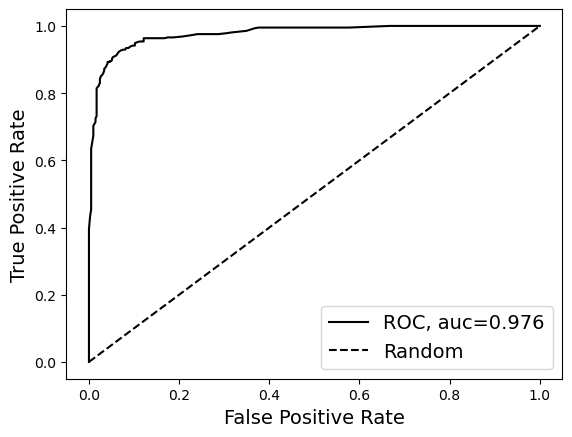

In [23]:
## ROC curve
y_probs = rfc_mdl.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_probs)
auc = metrics.roc_auc_score(y_test, y_probs)
plt.plot(fpr,tpr,label="ROC, auc="+str('%.3f' % auc),color='black')
plt.plot([0,1],[0,1],'--',label='Random',color='black')
plt.legend(loc=4,fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14);
#plt.savefig('nci_120d_roc.eps');


In [24]:
## bootstrap confidence interval for AUC
bootstrap(y_test,y_probs)

(0.9692003650327106, 0.9835680751173709)

### feature importance

We can extract feature importance from random forest models

For a few top features, we plot the distribution for graphs with label 0 and 1 respectively.

In [25]:
## top features
x = np.argsort(rfc_mdl.feature_importances_)
top = [x[i] for i in np.arange(len(x)-1,-1,-1)]
[features[i] for i in top[:15]]


['emb_26',
 'emb_0',
 'emb_32',
 'emb_7',
 'emb_47',
 'emb_36',
 'emb_5',
 'emb_28',
 'emb_46',
 'emb_58',
 'emb_49',
 'emb_19',
 'emb_9',
 'emb_22',
 'emb_1']

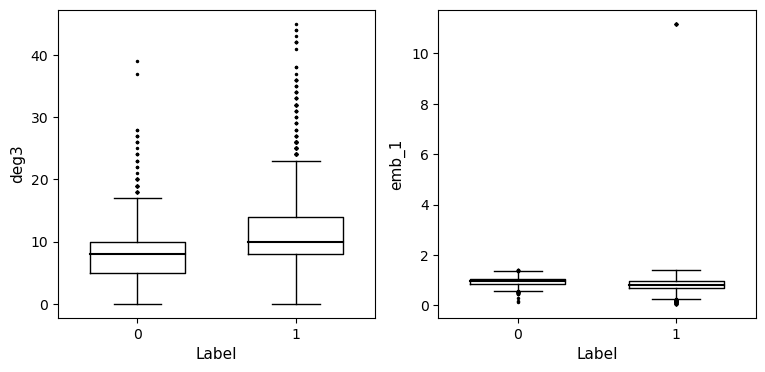

In [26]:
## manually pick a few features to show
f = ['deg3','emb_1']

plt.subplots(1,2,figsize=(9,4))

plt.subplot(121)
a = Fp[Fp['label']==0][f[0]]
b = Fp[Fp['label']==1][f[0]]
plt.boxplot([a,b],labels=['0','1'],widths=.6, 
            flierprops = dict(marker='.', markerfacecolor='black', markersize=3,linestyle='none'),
            medianprops = dict(linestyle='-', linewidth=1.5, color='black'))
plt.ylabel(f[0],fontsize=11)
plt.xlabel('Label',fontsize=11);

plt.subplot(122)
a = Fp[Fp['label']==0][f[1]]
b = Fp[Fp['label']==1][f[1]]
plt.boxplot([a,b],labels=['0','1'],widths=.6, 
            flierprops = dict(marker='.', markerfacecolor='black', markersize=3,linestyle='none'),
            medianprops = dict(linestyle='-', linewidth=1.5, color='black'))
plt.ylabel(f[1],fontsize=11)
plt.xlabel('Label',fontsize=11);
#plt.savefig('nci_features.eps');


## Unsupervised learning

We perform simple k-means clustering (fixing k to 10) and explore the content of the different clusters.

We plot the proportion of graphs with label == 1 vs the size of the cluster.

We see several small clusters with a large proportion of graphs with label == 1.


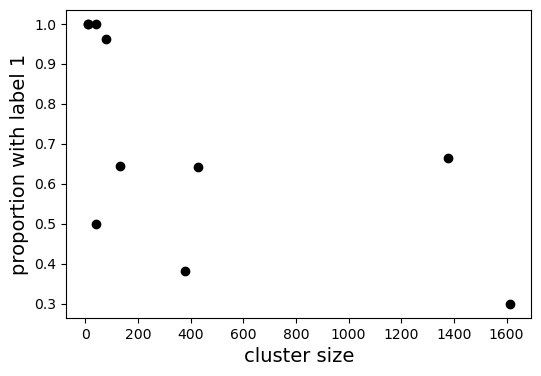

In [27]:
NCL = 10 ## number of clusters
from sklearn.cluster import KMeans
cl = KMeans(n_clusters=NCL, n_init=10).fit(U).labels_
K = pd.DataFrame(np.array([gl,cl,np.repeat(1,len(gl))]).transpose(),columns=['label=1','cluster','total'])
C = K.groupby(by='cluster').sum()
C['ratio'] = C['label=1']/C['total']
plt.figure(figsize=(6,4))
plt.plot(C['total'],C['ratio'],'o',color='black')
plt.xlabel('cluster size', fontsize=14)
plt.ylabel('proportion with label 1', fontsize=14);
#plt.savefig('kmeans_1.eps');

In [28]:
## same data in a table
df = C.sort_values(by='ratio',ascending=False).round(decimals=3)
df


,label=1,total,ratio
cluster,,,
1,41,41,1.000
7,10,10,1.000
8,8,8,1.000
5,74,77,0.961
3,914,1378,0.663
4,85,132,0.644
0,275,429,0.641
9,21,42,0.500
6,145,379,0.383


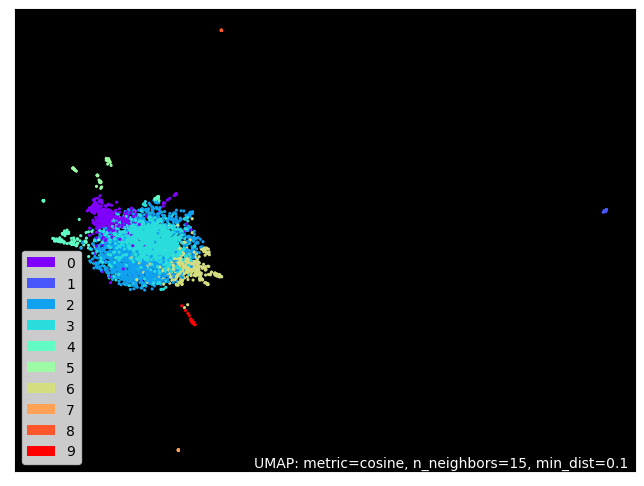

In [29]:
Um = umap.UMAP(metric='cosine').fit(D)
umap.plot.points(Um, labels=cl, width=800, height=600, theme='fire');

In [30]:
## we typically find a small 'pure' cluster of size 10
## look at this small cluster:
CL = df.index[df['total'] == 10][0]
df = F.loc[[i for i in range(len(cl)) if cl[i]==CL]][['nodes','edges','assort','deg1','deg2','deg3','label']]
df


,nodes,edges,assort,deg1,deg2,deg3,label
2077,82,97,-0.465995,10,36,32,1
2078,88,103,-0.494124,12,38,34,1
2079,78,93,-0.513733,8,35,32,1
2080,82,96,-0.467626,11,35,33,1
2081,86,101,-0.535722,11,37,35,1
2082,78,93,-0.513733,8,35,32,1
3833,80,94,-0.494897,10,35,32,1
3842,79,93,-0.506528,10,34,32,1
3843,80,95,-0.506849,9,35,33,1
3989,90,105,-0.477663,13,39,33,1


In [33]:
G.vs['label'] = G.degree()

label: 1


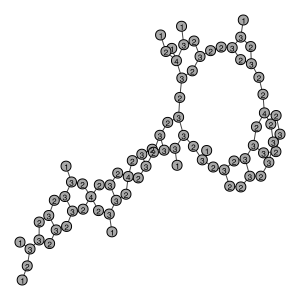

In [34]:
## plot some of those -- should be similar
gp = df.index[0] 
v = [v for v in G.vs if v['graph']==gp+1]
sg = G.subgraph(v)
print('label:',gl[gp])
ig.plot(sg,bbox=(0,0,300,300))

label: 1


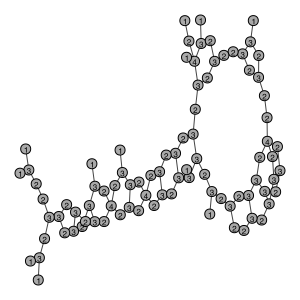

In [35]:
## another one -- 
gp = df.index[1] 
v = [v for v in G.vs if v['graph']==gp+1]
sg = G.subgraph(v)
print('label:',gl[gp])
ig.plot(sg,bbox=(0,0,300,300))